## `Introduction`


YouTube stands as the world's foremost video-sharing platform, drawing in over 2 billion logged-in users each month who watch more than a billion hours of video daily. Understanding the factors that cause videos to trend on the platform is incredibly valuable for content creators, marketers, and researchers. This notebook provides an in-depth analysis of trending YouTube videos from Canada, aiming to uncover the key patterns and elements that drive video popularity and success.

## `Research Questions`


`In this analysis, we seek to answer the following questions:`

`1. Category-Based Insights`

- Which category_name has the highest average views or trending frequency?

- How do viewer engagement metrics differ across categories like Music, News, Gaming, etc.?

- What trends can we observe overall?
  
`2. Engagement & Popularity`

- Which engagement metric (likes, dislikes, comments) most strongly correlates with trending success (views)?

- Are videos with higher like-to-dislike ratios more likely to have higher view counts?

- Do videos with comments disabled or ratings disabled trend differently than those with full engagement enabled?

`3. Temporal Analysis`

- What is the average time delay between publish_time and trending_date across categories?

- Are there specific days of the week or times of day where videos are more likely to trend?

- How does the trending frequency vary across different months or seasons?

`4. Content Metadata & Strategy`

- Do certain tags or patterns in tags appear more frequently in trending videos?

- How does title length or presence of clickbait-style words (e.g., "shocking", "you won’t believe") affect views or engagement?

`5. Creator & Channel Influence`

- Which channel_title consistently appears on the trending list, and what are their common traits?

- Do channels with repeated trending videos use consistent video formats, or categories?

`6. Video Status & Restrictions`

- What is the impact of comments_disabled, ratings_disabled, or video_error_or_removed on engagement?

- Do videos that are later removed or error out tend to have unusually high or low engagement?


## `Imports and Setup`

In [1]:
# This lets Python find and import modules located two folders above the current directory.

import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent.parent)) 

In [2]:
from pathlib import Path
from src.preprocessing.merge_datasets import dataset_merger
from src.preprocessing.data_utils import *
from src.analysis.category_trends import *
from src.analysis.engagement import *
from src.visualization.plot_engagement import *
from src.visualization.plot_trends import *

`Dataset Merge: Canada (Videos + Categories)`

Merging `CAvideos.csv` with `CA_category_id.json` using a right join to retain all category records.  
File paths are converted from `Path` objects to strings to ensure compatibility with the merging function.


In [3]:
CA_csv_path = Path("../../data/CA/CAvideos.csv")
CA_json_path= Path("../../data/CA/CA_category_id.json")

CA_data = dataset_merger([str(CA_csv_path), str(CA_json_path)], how='right')
CA_data.head(3)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name
0,FyZMnhUtLfE,17.14.11,猎场 | Game Of Hunting 12【TV版】（胡歌、張嘉譯、祖峰等主演）,大劇獨播,1,2017-11-12T16:00:01.000Z,"電視劇|""大陸電視劇""|""猎场""|""职场""|""商战""|""爱情""|""都市""|""胡歌""|""陈龙""...",158815.0,218.0,30.0,186.0,https://i.ytimg.com/vi/FyZMnhUtLfE/default.jpg,False,False,False,Thanks for watching the drama! Help more peopl...,Film & Animation
1,fy-CuCzaPp8,17.14.11,Rooster Teeth Animated Adventures - Drunk Baby...,Rooster Teeth,1,2017-11-13T14:00:03.000Z,"Rooster Teeth|""RT""|""animation""|""television""|""f...",308568.0,19541.0,70.0,495.0,https://i.ytimg.com/vi/fy-CuCzaPp8/default.jpg,False,False,False,Miles gets stuck at work one night watching ov...,Film & Animation
2,kzwfHumJyYc,17.14.11,Sharry Mann: Cute Munda ( Song Teaser) | Parmi...,Lokdhun Punjabi,1,2017-11-12T12:20:39.000Z,"sharry mann|""sharry mann new song""|""sharry man...",1096327.0,33966.0,798.0,882.0,https://i.ytimg.com/vi/kzwfHumJyYc/default.jpg,False,False,False,Presenting Sharry Mann latest Punjabi Song Cu...,Film & Animation


## `Preprocessing`

In [4]:
# Remove columns that are irrelevant or not useful for exploratory analysis,
# such as unique IDs, thumbnail URLs, and long unstructured text fields

columns_to_drop = [
    'thumbnail_link',
    'category_id',
    'description'
]

CA_data = drop_columns(CA_data, columns_to_drop)

In [5]:
CA_data.isna().sum()

video_id                  15
trending_date             15
title                     15
channel_title             15
publish_time              15
tags                      15
views                     15
likes                     15
dislikes                  15
comment_count             15
comments_disabled         15
ratings_disabled          15
video_error_or_removed    15
category_name              0
dtype: int64

Since it's only 15 missing rows out of thousands, it's safe to drop those rows entirely.

In [6]:
# Drop rows with missing values (15 rows only) to clean the dataset for EDA
CA_data = handle_missing_values(CA_data, strategy='drop')

In [7]:
# Convert the 'trending_date' column in CA_data to datetime format.
# The original format is 'yy.dd.mm' (e.g., '17.14.11' for 14th November 2017).
CA_data = convert_to_datetime(CA_data, 'trending_date', '%y.%d.%m')

# Convert the 'publish_time' column to datetime format using pandas.
# This ensures that we can perform date/time operations or filtering.
CA_data['publish_time'] = pd.to_datetime(CA_data['publish_time'])


`Extract date parts from publish_time`

In [8]:
CA_data['publish_day'] = CA_data['publish_time'].dt.date
CA_data['publish_hour'] = CA_data['publish_time'].dt.hour
CA_data['publish_weekday'] = CA_data['publish_time'].dt.day_name()

`Calculate "Days to Trend"`

In [9]:
#Poth without timezone
CA_data['publish_time'] = CA_data['publish_time'].dt.tz_localize(None)

CA_data['days_to_trend'] = (CA_data['trending_date'] - CA_data['publish_time']).dt.days

In [10]:
CA_data.head(3)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,category_name,publish_day,publish_hour,publish_weekday,days_to_trend
0,FyZMnhUtLfE,2017-11-14,猎场 | Game Of Hunting 12【TV版】（胡歌、張嘉譯、祖峰等主演）,大劇獨播,2017-11-12 16:00:01,"電視劇|""大陸電視劇""|""猎场""|""职场""|""商战""|""爱情""|""都市""|""胡歌""|""陈龙""...",158815.0,218.0,30.0,186.0,False,False,False,Film & Animation,2017-11-12,16,Sunday,1
1,fy-CuCzaPp8,2017-11-14,Rooster Teeth Animated Adventures - Drunk Baby...,Rooster Teeth,2017-11-13 14:00:03,"Rooster Teeth|""RT""|""animation""|""television""|""f...",308568.0,19541.0,70.0,495.0,False,False,False,Film & Animation,2017-11-13,14,Monday,0
2,kzwfHumJyYc,2017-11-14,Sharry Mann: Cute Munda ( Song Teaser) | Parmi...,Lokdhun Punjabi,2017-11-12 12:20:39,"sharry mann|""sharry mann new song""|""sharry man...",1096327.0,33966.0,798.0,882.0,False,False,False,Film & Animation,2017-11-12,12,Sunday,1


##### Data is Ready for Analysis

Now that the dataset has been cleaned and all relevant features have been extracted, we are ready to begin the Exploratory Data Analysis (EDA). The final dataframe includes the following columns:

- `video_id`
- `trending_date`
- `title`
- `channel_title`
- `publish_time`
- `tags`
- `views`
- `likes`
- `dislikes`
- `comment_count`
- `comments_disabled`
- `ratings_disabled`
- `video_error_or_removed`
- `category_name`
- `publish_day`
- `publish_hour`
- `publish_weekday`
- `days_to_trend`

Let's move on to uncover trends, patterns, and insights!


## `Analysis`

### `1. Category-Based Insights`

- Which category_name has the highest average views or trending frequency?

- How do viewer engagement metrics differ across categories like Music, News, Gaming, etc.?

- What trends can we observe overall?

In [11]:
extract_categories(CA_data, category_column='category_name')

['Film & Animation',
 'Autos & Vehicles',
 'Music',
 'Pets & Animals',
 'Sports',
 'Travel & Events',
 'Gaming',
 'People & Blogs',
 'Comedy',
 'Entertainment',
 'News & Politics',
 'Howto & Style',
 'Education',
 'Science & Technology',
 'Movies',
 'Shows']

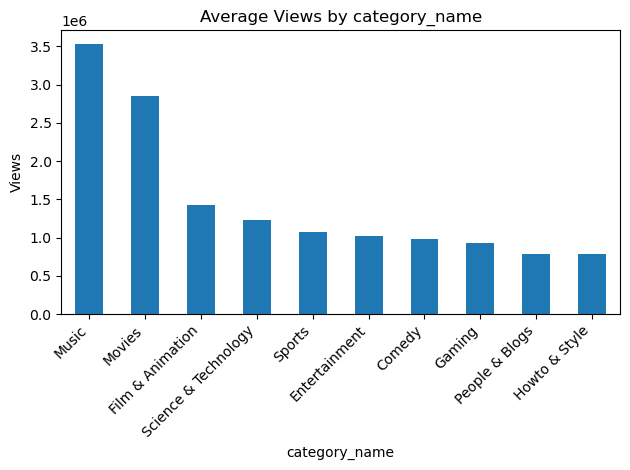

In [12]:
fig = plot_trend_comparison(CA_data,group_col='category_name', value_col='views' )
plt.show()

path = '../../outputs/plots/country_specific/CA/avg viows by category name'
export_trend_plot(fig, str(path))

- `Which category has the highest average views or trending frequency?`

    Looks like Music is the king of views, but Movies are catching up! What’s your favorite category?

In [13]:
growth_monthly =calculate_category_growth(data=CA_data.rename(columns={'trending_date': 'date'}),\
                                           category_column='category_name', value_column='views', top_n=5, freq="M")

path = '../../outputs/tables/country_specific/CA/Top 5 Category Growth Monthly'
save_table(growth_monthly, str(path), format='csv')
growth_monthly

category_name,Comedy,Entertainment,Music,People & Blogs,Sports
period,,,,,
2017-11-01,0.000000,0.000000,0.000000,0.000000,0.000000
2017-12-01,88.306250,258.371454,74.808837,86.651464,85.590107
2018-01-01,-38.335486,-50.533656,-21.255362,-22.717898,-7.626739
2018-02-01,1.119046,12.228877,-11.842743,74.372517,28.348224
2018-03-01,-0.145888,8.902760,27.232892,-28.236870,7.525184
2018-04-01,-7.716287,-7.838146,-15.355549,-7.523605,-39.913345
2018-05-01,23.511684,15.065015,56.986779,19.684205,9.500627
2018-06-01,-64.249147,-43.084838,-57.283644,-45.236758,-38.914860


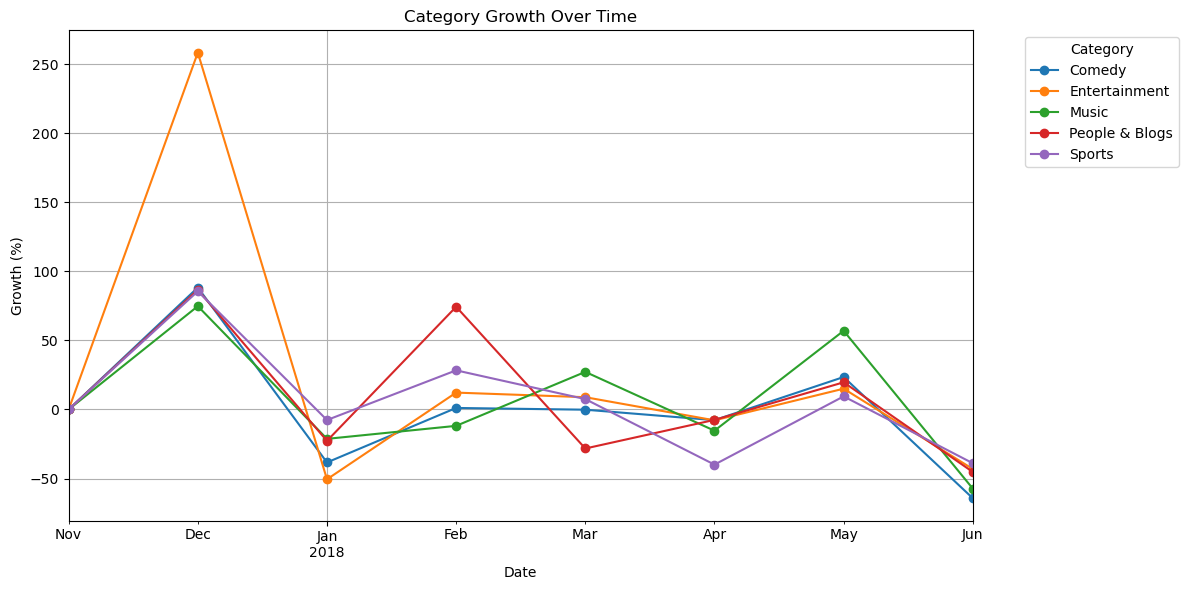

In [14]:
fig = plot_category_growth(growth_monthly)

path = '../../outputs/plots/country_specific/CA/Category Growth Over Time'
export_trend_plot(fig, str(path))

- `What trends can we observe overall?`

    Entertainment and People & Blogs show more fluctuation, indicating varied user interest.

    Comedy and Music show more stable trends.

    There's often a dip around January, likely due to post-holiday engagement drop.


- After a little research, here’s a summary of key entertainment happenings in Canada during December 2017:

    December 2017 was a lively month for Canada's entertainment industry. It featured major concerts, theatrical staples like The Nutcracker, and national celebrations tied to Canada’s 150th anniversary. Cultural vibrancy was seen coast-to-coast, with events ranging from classical ballet and children’s theatre to live electronic music and art exhibitions. The mix of traditional and pop-culture events likely contributed to the spike in engagement in the "Entertainment" category on YouTube in Canada during this period.

In [15]:
category_engagement =  summarize_engagement_by_category_df(CA_data)

path = '../../outputs/tables/country_specific/CA/Avg Eategory Engagement '
save_table(category_engagement, str(path), format='csv')

category_engagement

,category_name,video_count,total_likes,total_comments,total_views,avg_engagement_rate
0,Autos & Vehicles,353,4732114.0,1016188.0,2.000661e+08,3.875079
1,Comedy,3773,196046674.0,19638776.0,3.708439e+09,5.801994
2,Education,991,20972402.0,2968416.0,5.317733e+08,5.074712
3,Entertainment,13451,387245433.0,55313036.0,1.367122e+10,3.149489
4,Film & Animation,2060,77802003.0,10086573.0,2.939061e+09,3.422391
5,Gaming,1344,51726552.0,9664887.0,1.241532e+09,5.814060
6,Howto & Style,2007,51183104.0,8342917.0,1.570847e+09,5.761934
7,Movies,6,252905.0,13979.0,1.712049e+07,2.234778
8,Music,3731,564447530.0,52435252.0,1.317985e+10,5.302652
9,News & Politics,4159,32705054.0,9259788.0,1.614610e+09,3.076991


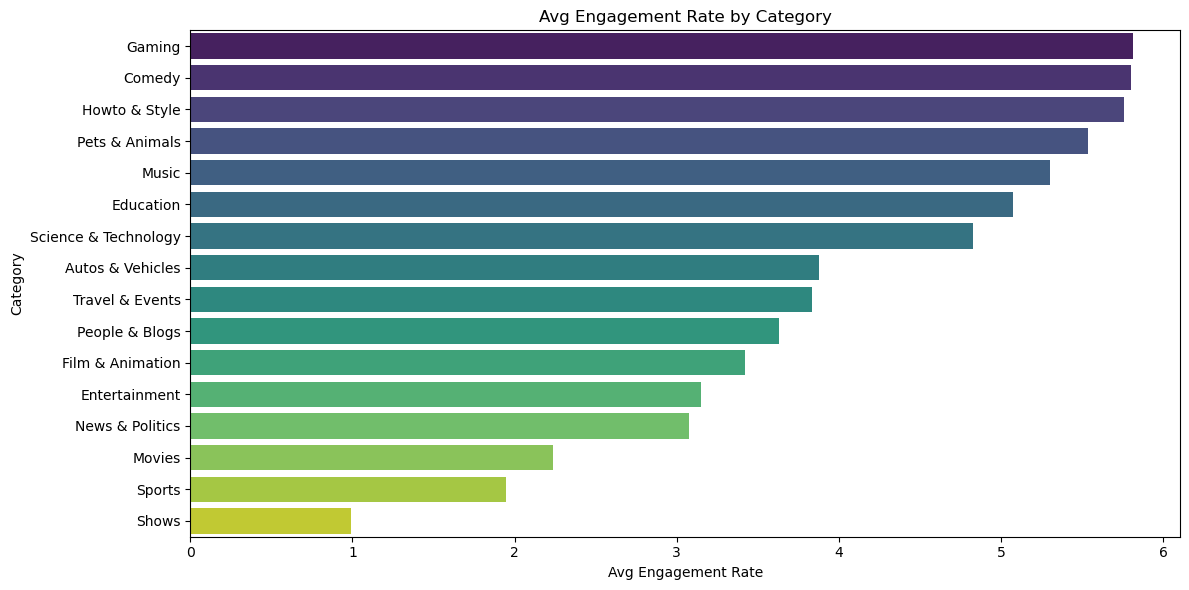

In [16]:
fig = plot_category_engagement(category_engagement)

path = '../../outputs/plots/country_specific/CA/Avg Engagement Rate By Category'
export_trend_plot(fig, str(path))

- `How do viewer engagement metrics differ across categories like Music, News, Gaming, etc.?`


- `Engagement Rate (%)`

**Engagement Rate (%)** = ((likes + comment_count) ÷ views) × 100

*Note: Engagement rate was calculated using likes and comments only, as they are the most indicative of positive audience interaction.*

---

- `Description:`

**Engagement Rate (%)** is the percentage of viewers who interact with a video via likes or comments.
It is calculated as:

  **(likes + comment_count) ÷ views × 100**

This helps compare how interactive or appealing videos are.
**Higher rates** mean more engaged audiences, not just viewers.

---

- `Highest Engagement Rate Categories`

| Category           | Engagement Rate (%) |
| ------------------ | ------------------- |
| **Gaming**         | **5.81**            |
| **Comedy**         | **5.80**            |
| **Howto & Style**  | **5.76**            |
| **Music**          | **5.30**            |
| **Pets & Animals** | **5.54**            |
| **Education**      | **5.07**            |

  Gaming and Comedy lead with the highest average engagement rates (~5.8%), meaning users in these categories are highly interactive, liking and commenting more relative to views.

  Music also performs very well, benefiting from massive viewership and strong engagement.

  Niche categories like Pets & Animals and Howto & Style also show strong engagement, likely due to community interest or personal relevance.


- `Lower Engagement Rate Categories`

| Category            | Engagement Rate (%) |
| ------------------- | ------------------- |
| **Shows**           | **0.99**            |
| **Sports**          | **1.95**            |
| **Movies**          | **2.23**            |
| **News & Politics** | **3.08**            |
| **Entertainment**   | **3.15**            |

  Shows, Sports, and News have much lower engagement rates. Despite some having high view counts, users are less likely to like or comment.

  Possible reasons:

 News & Politics: Often consumed passively or with polarizing content that may discourage interaction.

 Shows/Movies: Users may watch but not engage due to platform behavior or format.

 Sports: High views, but fans may interact elsewhere (e.g., forums, live streams).

---

- `Key Insights:`

Engagement ≠ Views: High viewership (e.g., in Entertainment or Sports) doesn't always correlate with a high engagement rate.

Interactive Categories: Gaming, Comedy, and Music foster more user interaction — ideal for creators seeking active communities.

Low-Engagement Content: News, Movies, and Shows tend to be passively consumed, suggesting different content strategies.


### `2. Engagement & Popularity`

- Which engagement metric (likes, dislikes, comments) most strongly correlates with trending success (views)?

- Are videos with higher like-to-dislike ratios more likely to have higher view counts?

- Do videos with comments disabled or ratings disabled trend differently than those with full engagement enabled?

In [17]:
print_engagement_correlation_before_trend(CA_data)


 Correlation Between Pre-Trend Daily Engagement and Trending Success (Views/day)

- Likes/day      : 0.816
- Dislikes/day   : 0.778
- Comments/day   : 0.546


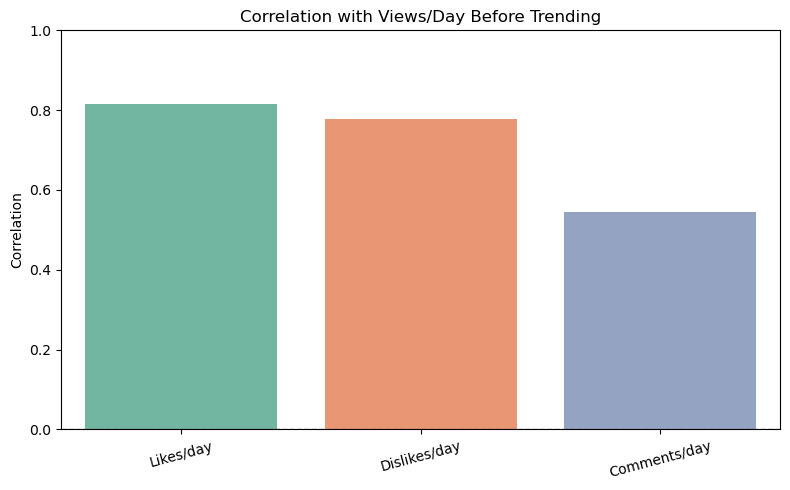

In [18]:
engagement_correlation_before_trend = plot_engagement_correlation_before_trend(CA_data)
plt.show()

path = '../../outputs/plots/country_specific/CA/Correlation With Views Per Day Before Trending'
export_trend_plot(engagement_correlation_before_trend, str(path))

- `Insights: Correlation Between Pre-Trend Engagement and Views per Day`

This analysis focuses on the engagement that occurred before the video trended, calculated on a per-day basis (from publish date to trending date).

- Likes/day (0.816) show the strongest positive correlation with trending views per day, suggesting that frequent positive feedback plays a major role in a video's trending success.

- Dislikes/day (0.778) also show a surprisingly strong correlation. This may indicate that controversial or polarizing content can attract attention and contribute to virality.

- Comments/day (0.546) have a moderate correlation. While user discussion helps, it's less predictive of trending compared to likes or dislikes.

- These findings imply that audience reaction speed — both positive and negative — is more influential than just comment volume when it comes to trending potential.

In [19]:
like_dislike_ratio_vs_views = like_dislike_ratio_vs_views(CA_data)

path = '../../outputs/tables/country_specific/CA/Like Dislike Ratio VS Views'
save_table(like_dislike_ratio_vs_views, path, format='csv')

like_dislike_ratio_vs_views

Correlation between like/dislike ratio and average views: -0.051


,category_name,avg_like_dislike_ratio,avg_views
8,Music,52.382317,3.532525e+06
7,Movies,25.098648,2.853415e+06
4,Film & Animation,44.528153,1.426729e+06
12,Science & Technology,40.677333,1.233845e+06
14,Sports,30.002493,1.075584e+06
3,Entertainment,40.194528,1.016372e+06
1,Comedy,60.605091,9.828886e+05
5,Gaming,72.271736,9.237592e+05
10,People & Blogs,45.805530,7.864136e+05
6,Howto & Style,67.445786,7.826839e+05


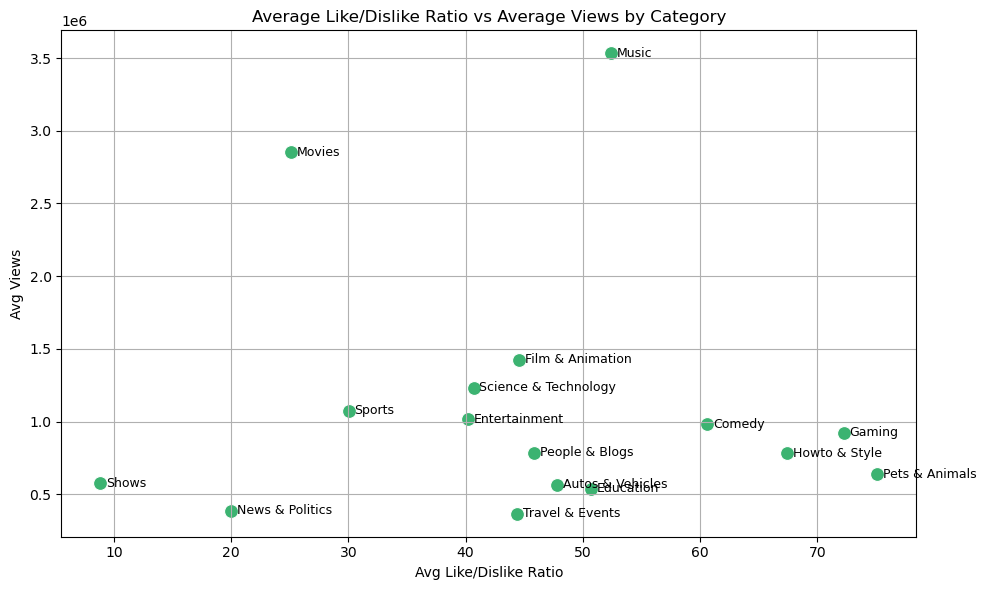

In [20]:
plot_like_dislike_ratio_vs_views = plot_like_dislike_ratio_vs_views(like_dislike_ratio_vs_views)
plt.show()

path = '../../outputs/plots/country_specific/CA/Like Dislike Ratio VS Views'
export_trend_plot(plot_like_dislike_ratio_vs_views, str(path))

- `Like-to-Dislike Ratio vs View Count Insights`

The analysis explores whether videos with higher like-to-dislike ratios are associated with higher average view counts across different categories.

*There appears to be no strong direct correlation between a high like/dislike ratio and high view counts.*

- For example:

Gaming and Pets & Animals have some of the highest like/dislike ratios (72.3 and 75.1), yet their average views are relatively moderate (under 1M).

In contrast, the Music category has a moderate ratio (52.4) but the highest average views (~3.5M).

Shows have the lowest ratio (8.8) and also relatively low views, suggesting very low audience satisfaction may correlate with lower success—but it's not consistent across the board.

- `Conclusion:`
  
While a low like/dislike ratio might be associated with lower success, a high ratio alone is not a strong predictor of trending performance. Other factors like category popularity, content type, or timing likely play a more dominant role.

In [21]:
engagement_disabled_analysis = engagement_disabled_analysis(CA_data)

path = '../../outputs/tables/country_specific/CA/Engagement Disabled Analysis'
save_table(engagement_disabled_analysis, path, format='csv')

engagement_disabled_analysis

,comments_disabled,ratings_disabled,avg_views,avg_likes,avg_comments,count
0,False,False,1.148426e+06,39979.254992,5066.893510,40013
1,False,True,3.903296e+05,0.000000,928.159624,213
2,True,False,8.553432e+05,15921.496139,0.000000,518
3,True,True,4.733370e+06,0.000000,0.000000,63


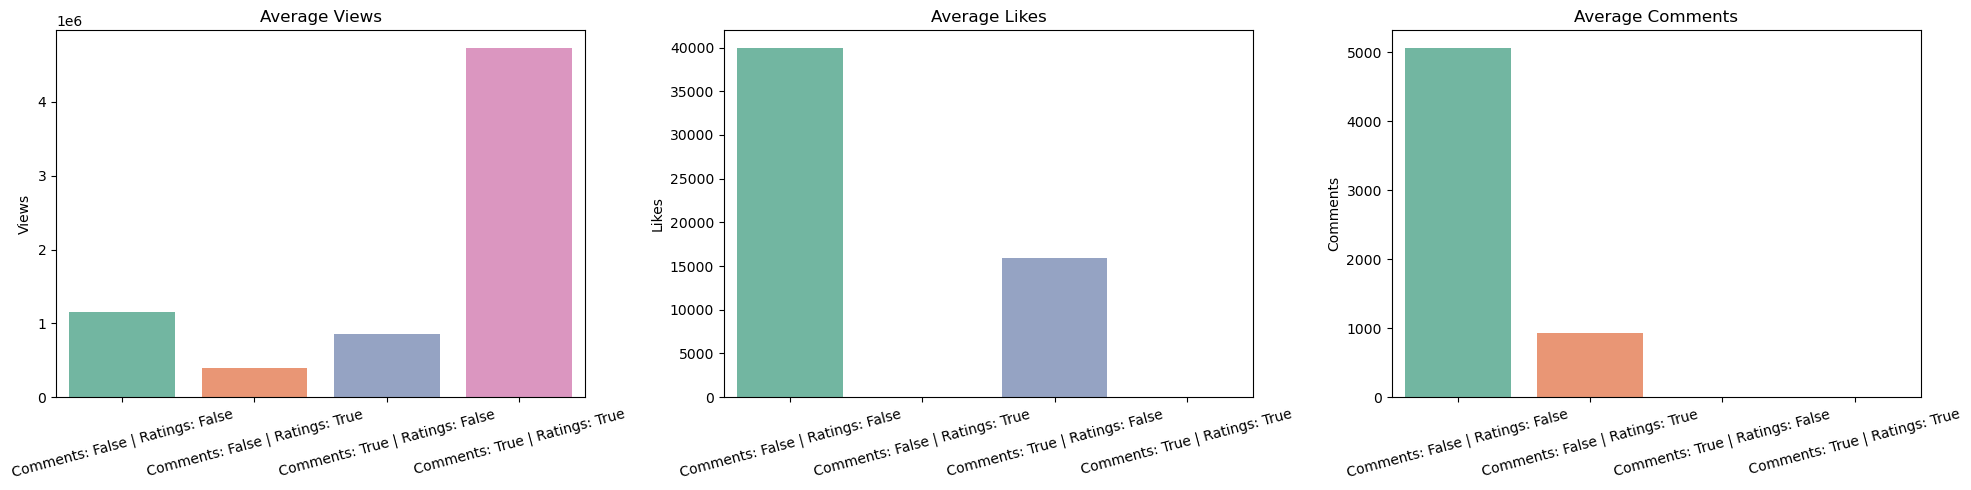

In [22]:
plot_engagement_disabled_stats =  plot_engagement_disabled_stats(CA_data)
plt.show()
path = '../../outputs/plots/country_specific/CA/Engagement Disabled Stats'
export_trend_plot(plot_engagement_disabled_stats, str(path))


| Comments Disabled | Ratings Disabled | Avg Views | Avg Likes | Avg Comments | Video Count |
| ----------------- | ---------------- | --------- | --------- | ------------ | ----------- |
| ❌ No              | ❌ No             | **1.15M**     | 39.9K     | 5.1K         | 40,013      |
| ❌ No              | ✅ Yes            | **390K**  | 0         | 928          | 213         |
| ✅ Yes             | ❌ No             | **855K**  | 15.9K     | 0            | 518         |
| ✅ Yes             | ✅ Yes            | **4.73M** | 0         | 0            | 63          |


- `Observations:`

Videos with both comments and ratings disabled show the highest average views (4.7M), but this group is very small (only 63 videos), possibly outliers or special cases (e.g., trailers, corporate announcements).

Disabling only ratings correlates with significantly lower average views (390K) and zero likes—expected since likes/dislikes are disabled.

Videos with all features enabled have the most consistent and well-rounded engagement (likes + comments) and a healthy average view count (1.15M).

- `Conclusion:`

While most popular videos tend to keep engagement features enabled, a very small set of videos with both features disabled may still trend—likely due to external promotion or existing fanbase. Overall, enabling engagement seems correlated with stronger performance, but context matters.

### `3. Temporal Analysis`

- What is the average time delay between publish_time and trending_date across categories?

- Are there specific days of the week or times of day where videos are more likely to trend?

- How does the trending frequency vary across different months or seasons?

In [23]:
average_days_to_trend_by_category = average_days_to_trend_by_category(CA_data)

path = '../../outputs/tables/country_specific/CA/average_days_to_trend_by_category'
save_table(average_days_to_trend_by_category, path, format='csv')

average_days_to_trend_by_category

,category_name,avg_days_to_trend
0,Shows,1.103448
1,Travel & Events,1.553398
2,Howto & Style,1.684834
3,Pets & Animals,2.000000
4,Sports,2.058207
5,Movies,2.500000
6,News & Politics,2.779077
7,Entertainment,3.167174
8,Gaming,4.345313
9,Education,4.976190


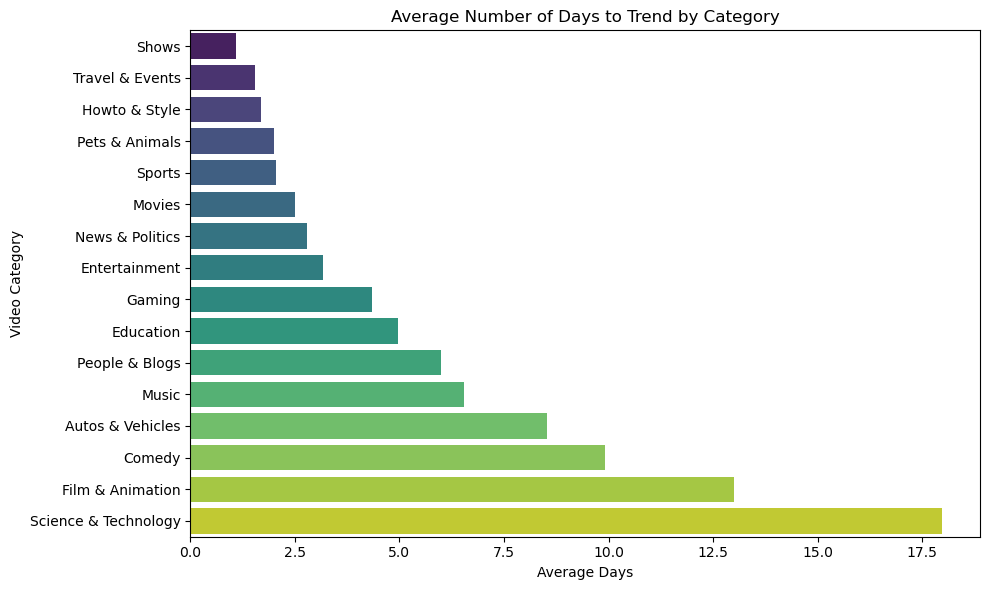

In [24]:
fig = plot_avg_days_to_trend_by_category(average_days_to_trend_by_category)
plt.show()

path = '../../outputs/plots/country_specific/CA/Average Number of Days to Trend by Category'
export_trend_plot(fig, str(path))

- `Summary: Average Days to Trend by Category`

- **Fastest to Trend**  
  - *Shows*, *Travel & Events*, and *Howto & Style* trend in under **2 days**.  
  - This suggests high immediacy and rapid viewer engagement.

- **Moderate Speed**  
  - Categories like *News & Politics*, *Entertainment*, and *Gaming* trend in **2–4 days**.  
  - These reflect consistent interest from broader audiences.

- **Slowest to Trend**  
  - *Comedy*, *Film & Animation*, and *Science & Technology* take **9–18 days** to trend.  
  - Indicates slower discovery, possibly due to niche topics or long-form content.

- **Notable Outlier**  
  - *Science & Technology* averages **~18 days**, making it the slowest by a wide margin.

- **Implications**  
  - **Fast-trending** categories benefit from viral and timely content.  
  - **Slow-trending** ones may require sustained visibility and are often more evergreen.


In [25]:
trending_day_distribution = trending_day_distribution(CA_data)

path = '../../outputs/tables/country_specific/CA/trending_day_distribution'
save_table(trending_day_distribution, path, format='csv')

trending_day_distribution

,publish_weekday,count
0,Monday,5861
1,Tuesday,5858
2,Wednesday,5504
3,Thursday,5945
4,Friday,7006
5,Saturday,5239
6,Sunday,5394


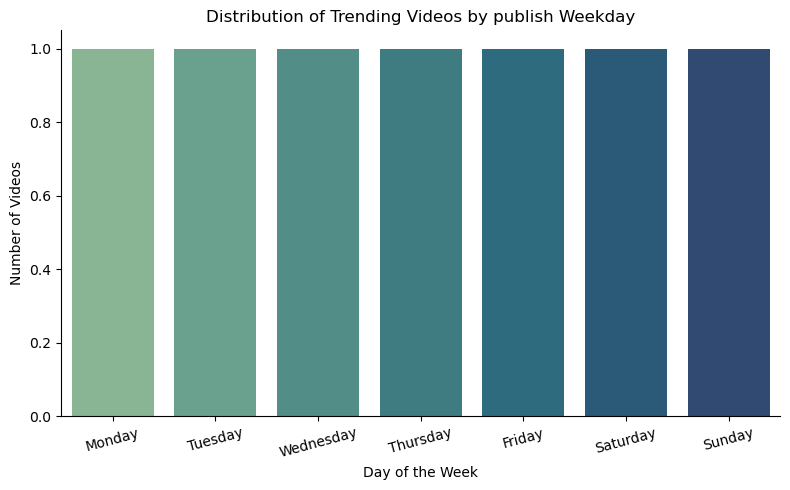

In [26]:
fig = plot_trending_day_distribution(trending_day_distribution)
plt.show()

path = '../../outputs/plots/country_specific/CA/Distribution of Trending Videos by publish Weekday'
export_trend_plot(fig, str(path))

- `Insights on Trending Video Distribution by Weekday`

- **Friday** has the **highest number of trending videos** with **7,006**, suggesting that content published on Fridays may have a better chance of trending. This could be due to increased user engagement before the weekend.

- **Thursday** (5,945) and **Monday** (5,861) also show strong performance, indicating that both the start and end of the workweek are effective periods for content to gain traction.

- **Saturday** (5,239) and **Sunday** (5,394) have the **lowest counts**, possibly because fewer videos are published, or user behavior differs during weekends.

- **Wednesday** (5,504) marks a dip in trending activity, potentially signaling a mid-week lull in video performance.

>  **Insight:** Publishing videos toward the **end of the workweek (Thursday–Friday)** may increase the likelihood of trending, based on historical data.


In [27]:
trending_by_month = trending_by_month(CA_data)
trending_by_month

path = '../../outputs/tables/country_specific/CA/trending_by_month'
save_table(trending_by_month, path, format='csv')

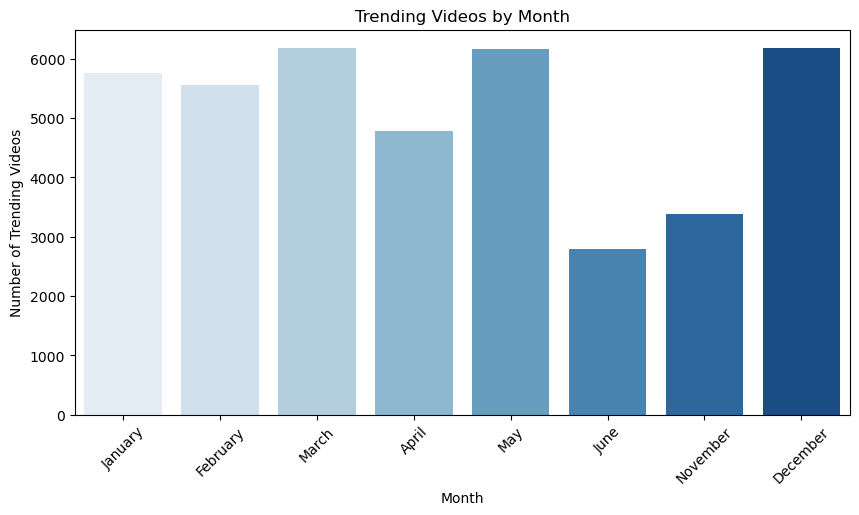

In [28]:
fig = plot_trending_by_month(trending_by_month)
plt.show()

path = '../../outputs/plots/country_specific/CA/Trending Videos by Month'
export_trend_plot(fig, str(path))

- `Insights on Trending Video Distribution by Month`

- **December (6,182 videos)** has the **highest trending activity**, likely driven by the holiday season and increased user engagement.

- **March (6,175)** and **May (6,166)** are also strong months, showing high content performance toward the end of Q1 and in mid-Q2.

- **April (4,781)** sees a noticeable drop, possibly due to content fatigue or seasonal distractions.

- **June (2,800)** has the **lowest number of trending videos**, indicating it might be a less optimal month for high exposure.

- **November (3,391)** also performs below average, possibly due to shifting audience attention as the year closes.

>  **Insight:** For maximum reach, content creators should consider publishing during **March, May, or December** when trending potential is at its peak.


### `4. Content Metadata & Strategy`

- Do certain tags or patterns in tags appear more frequently in trending videos?

- How does title length or presence of clickbait-style words (e.g., "shocking", "you won’t believe") affect views or engagement?

In [29]:
tag_data = analyze_top_tags_by_category(CA_data)
tag_data

{'Autos & Vehicles':            tag  count
 0  doug demuro    123
 1       demuro    104
 2        turbo     64
 3          diy     60
 4          car     45
 5         race     40
 6       nissan     39
 7          jdm     37
 8         mods     36
 9          how     35,
 'Comedy':           tag  count
 0       funny   1253
 1      comedy    959
 2       humor    526
 3   talk show    473
 4       trump    294
 5         nbc    290
 6      sketch    289
 7      nbc tv    285
 8  television    285
 9      parody    220,
 'Education':                   tag  count
 0             science    254
 1           education    211
 2               learn    123
 3               green    118
 4             scishow    115
 5                hank    115
 6      grant thompson    103
 7      random happens    102
 8      king of random     97
 9  the king of random     97,
 'Entertainment':                tag  count
 0            funny   1340
 1           comedy   1128
 2    entertainment    832
 3  

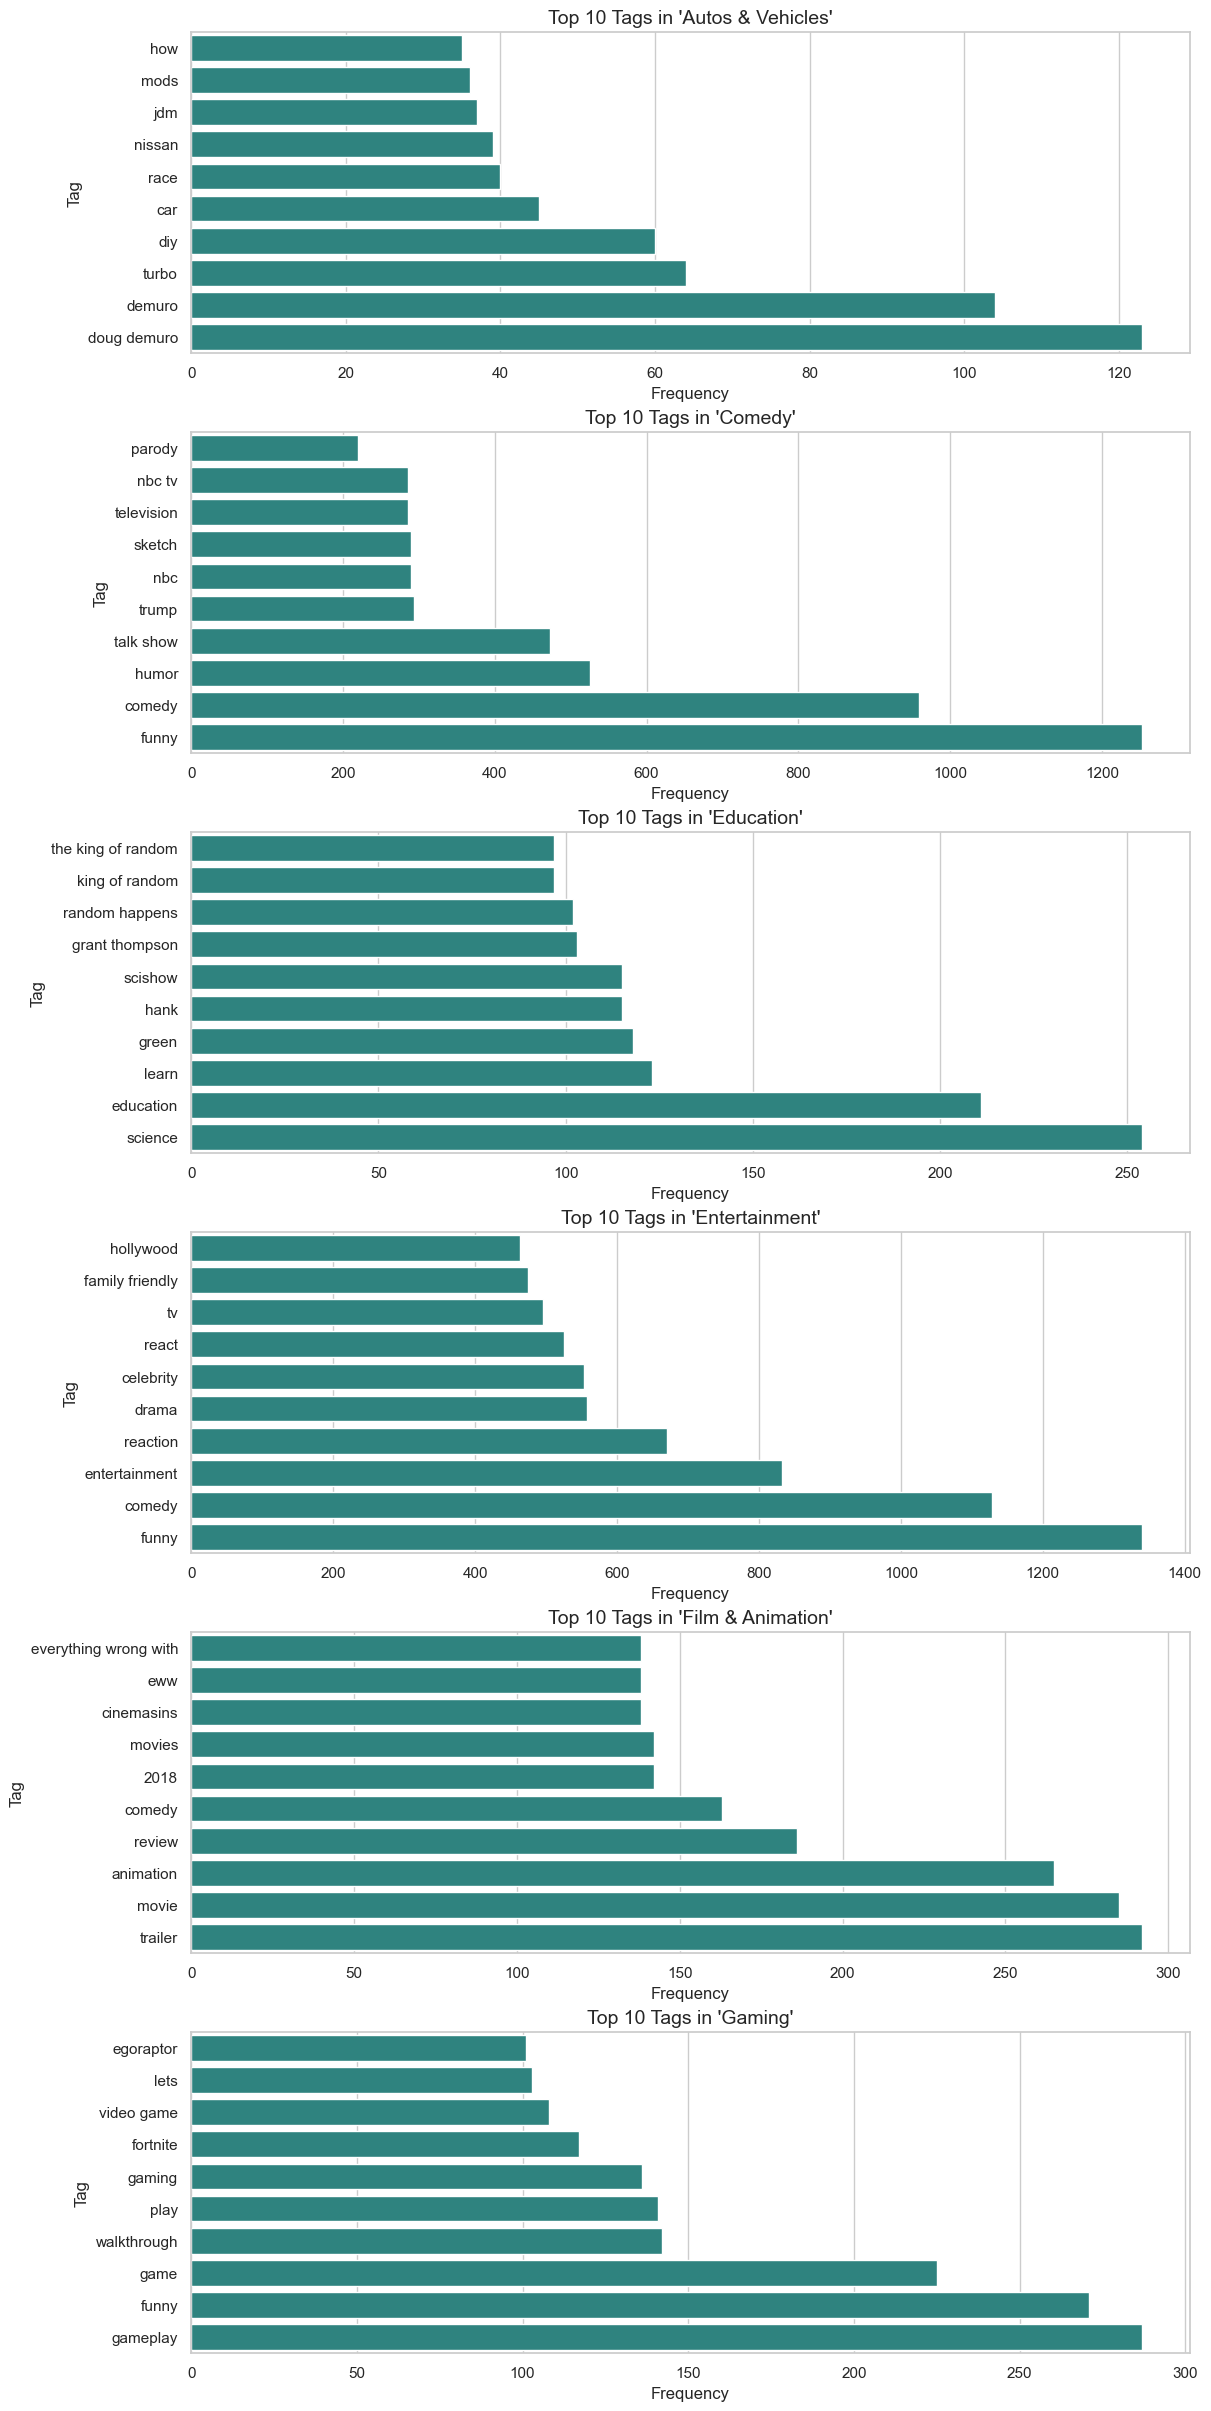

In [30]:
fig =visualize_top_tags_per_category(tag_data, max_categories=6)
plt.show()

path = '../../outputs/plots/country_specific/CA/Top 10 Tags Per Category'
export_trend_plot(fig, str(path))

- `YouTube Trending Tags Analysis by Category`

This analysis summarizes the top 10 tags for each YouTube video category based on their frequency. These tags help illustrate common themes, creator influence, and content trends across YouTube’s most popular genres.

---

 Top-Level Observations

1. **Recurrent Tags Across Categories**
Some tags appear frequently across multiple categories, showing broader viewer interest:

- **`funny`**: Found in *Entertainment*, *Comedy*, *Gaming*, and *People & Blogs*. Humor is a major draw across YouTube content.
- **`comedy`**: Also prevalent in multiple categories, including *Entertainment*, *Comedy*, and *People & Blogs*.
- **`review`**: Found in *Science & Technology* and *Film & Animation*, bridging content review formats in both tech and media.

---

2. **Category-Specific Creator or Brand Dominance**
Certain creators or branded series dominate specific categories:

- **Autos & Vehicles**: `doug demuro`, `nissan`, `jdm`, `mods`
- **Education**: `scishow`, `grant thompson`, `the king of random`
- **People & Blogs**: `joe rogan`, `buzzfeed`, `vlog`, `podcast`
- **Pets & Animals**: `coyote peterson`, `breaking trail`, `aquarium`
- **Travel & Events**: `mark wiens`, `the food ranger`, `street food`

These names and series have become synonymous with their content domains.

---

3. **Genre Saturation & Localization**
- **Music**: Heavy representation of **Punjabi** music tags such as `punjabi songs`, `latest punjabi songs 2018`, `hip hop`, and `rap`.
- **Movies**: Strong presence of tags related to the Punjabi movie _"Golak Bugni Bank Te Batua"_.
- **Shows**: Regional Tamil serials dominate with repeated references to *Priyamanaval*.

This localization indicates strong regional popularity and cultural segmentation in trending data.

---

4. **Overlap Between Reviews & Technology**
- Tags like `review`, `unboxing`, and `gadgets` in *Science & Technology* overlap with *Film & Animation* via `review` and `trailer`.
- Reflects audience interest in **both tech/product reviews and film content analysis**.

In [31]:
analyze_clickbait_effect_by_category = analyze_clickbait_effect_by_category(CA_data)

path = '../../outputs/tables/country_specific/CA/analyze_clickbait_effect_by_category'
save_table(analyze_clickbait_effect_by_category, path, format='csv')

analyze_clickbait_effect_by_category

,category_name,clickbait_in_title,views,likes,comment_count
0,Autos & Vehicles,False,5.675284e+05,13353.586207,2864.341954
1,Autos & Vehicles,True,5.132384e+05,17013.200000,3879.400000
2,Comedy,False,9.838004e+05,52059.615753,5216.360830
3,Comedy,True,7.544546e+05,27109.200000,2379.466667
4,Education,False,5.398803e+05,21321.628074,3016.338115
5,Education,True,3.233477e+05,10832.866667,1631.333333
6,Entertainment,False,1.014231e+06,28837.991628,4115.734564
7,Entertainment,True,1.408672e+06,19873.712329,3462.178082
8,Film & Animation,False,1.427209e+06,37752.358812,4894.099318
9,Film & Animation,True,1.262248e+06,43109.666667,5682.166667


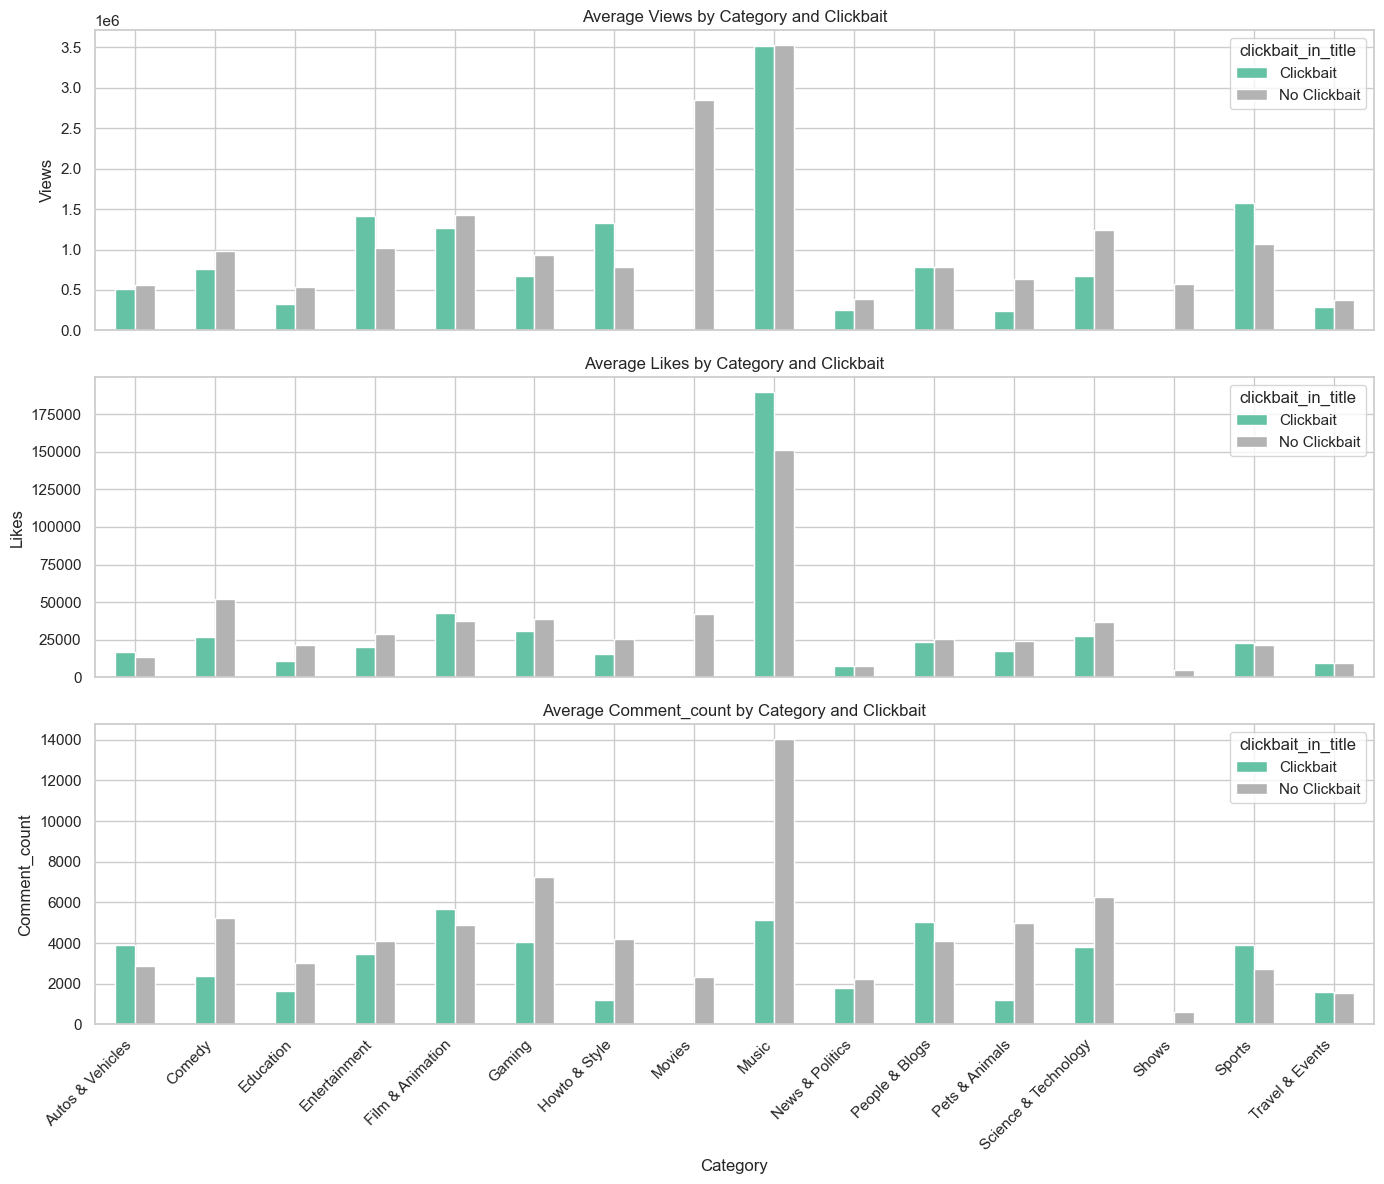

In [32]:
fig = plot_clickbait_effect_alternative(analyze_clickbait_effect_by_category)
plt.show()

- `Insights on Clickbait Impact by Category`

- `General Trends:`
- **Clickbait titles** don't consistently lead to higher engagement across all metrics and categories.
- In some categories, clickbait appears to **reduce engagement**, suggesting possible audience fatigue or mistrust.

- `Key Observations by Metric:`

**1. Views:**
- In categories like **Entertainment**, **Shows**, and **Science & Technology**, clickbait titles had **fewer average views** than non-clickbait ones.
- However, in **Howto & Style** and **Sports**, clickbait titles had **notably more views**, suggesting curiosity-driven clicks.

**2. Likes:**
- Clickbait titles tend to attract **fewer likes** in most categories (e.g., **Comedy**, **Gaming**, **Music**), possibly indicating lower viewer satisfaction.
- A notable exception is **Film & Animation**, where clickbait got more likes.

**3. Comment Count:**
- Clickbait slightly increases comments in some categories (**People & Blogs**, **Autos & Vehicles**), possibly due to more provocative or controversial content.
- But overall, clickbait doesn’t lead to a consistent increase in discussion.

- `Conclusion:`
- **Clickbait is not a guaranteed strategy**: While it can help in specific niches, in many cases it may harm overall engagement.
- Creators should evaluate its impact **category by category**, and focus on **authenticity** and content quality for sustainable results.


### `5. Creator & Channel Influence`

- Which channel_title consistently appears on the trending list, and what are their common traits?

- Do channels with repeated trending videos use consistent video formats, or categories?

In [33]:
top_trending_channels = summarize_top_trending_channels(CA_data)

path = '../../outputs/tables/country_specific/CA/top_trending_channels'
save_table(top_trending_channels, path, format='csv')

top_trending_channels

,channel_title,trending_count,unique_videos,avg_views,avg_likes,most_common_category
6,SET India,192,152,1.596544e+05,867.500000,Entertainment
3,MSNBC,189,152,2.478538e+05,2598.185185,News & Politics
2,FBE,188,89,1.012628e+06,32671.893617,Entertainment
8,The Young Turks,186,147,1.442968e+05,3603.198925,News & Politics
4,REACT,183,105,5.926489e+05,19044.196721,Entertainment
9,VikatanTV,182,158,6.331886e+05,3624.109890,Shows
1,CNN,180,115,4.503845e+05,4337.161111,News & Politics
7,The Late Show with Stephen Colbert,172,104,1.329257e+06,17922.755814,Entertainment
0,ARY Digital,168,132,3.694249e+05,2693.589286,Entertainment
5,RadaanMedia,168,148,3.609674e+05,1838.541667,Entertainment


- `Creator & Channel Influence: Key Insights`

1. **Most Consistently Trending Channels**:
   - `SET India` tops the list with **192** trending appearances, followed closely by `MSNBC` and `FBE`.
   - Channels like `CNN`, `The Young Turks`, and `The Late Show with Stephen Colbert` also show strong consistency in trending.

2. **Content Categories**:
   - The dominant category is clearly **Entertainment**, with 6 out of the top 10 channels belonging to it.
   - **News & Politics** is also well represented (`CNN`, `MSNBC`, `The Young Turks`), indicating high viewer engagement with current events.
   - Only one channel falls under the **Shows** category: `VikatanTV`.

3. **Video Volume vs. Influence**:
   - While `SET India` has the most trending entries, its **average views (159K)** and **likes (867)** are relatively low — likely due to a high volume of uploads.
   - In contrast, `FBE` and `The Late Show with Stephen Colbert` have **fewer unique videos**, but **much higher average views (1M+ and 1.3M)** and **likes (32K+ and 17K+)** — suggesting more impactful or viral content.

4. **Engagement Trends**:
   - `FBE` leads in audience interaction with **highest average likes (32K+)**, followed by `REACT` and `The Late Show with Stephen Colbert`.
   - This suggests a strong community or fan base around these channels, possibly due to viewer familiarity or participatory formats.

5. **Content Duplication vs. Variety**:
   - Channels like `VikatanTV` and `RadaanMedia` have a very high ratio of **trending count vs. unique videos**, which may suggest repetitive content or multiple clips from similar formats going viral.


In [34]:
analyze_channel_format_category_consistency = analyze_channel_format_category_consistency(CA_data)

path = '../../outputs/tables/country_specific/CA/analyze_channel_format_category_consistency'
save_table(analyze_channel_format_category_consistency, path, format='csv')

analyze_channel_format_category_consistency

,channel_title,trending_count,unique_categories,common_category,avg_tags_per_video,category_consistency
0,SET India,192,1,Entertainment,32.203125,0.994792
1,MSNBC,189,1,News & Politics,30.883598,0.994709
2,FBE,188,1,Entertainment,29.968085,0.994681
3,The Young Turks,186,1,News & Politics,30.376344,0.994624
4,REACT,183,2,Entertainment,26.103825,0.989071
...,...,...,...,...,...,...
804,iDubbbzTV,10,1,Comedy,11.500000,0.900000
805,Glenn Videos,10,1,Film & Animation,13.100000,0.900000
806,jypentertainment,10,1,Music,39.500000,0.900000
807,loveliveserve,10,1,Entertainment,20.200000,0.900000


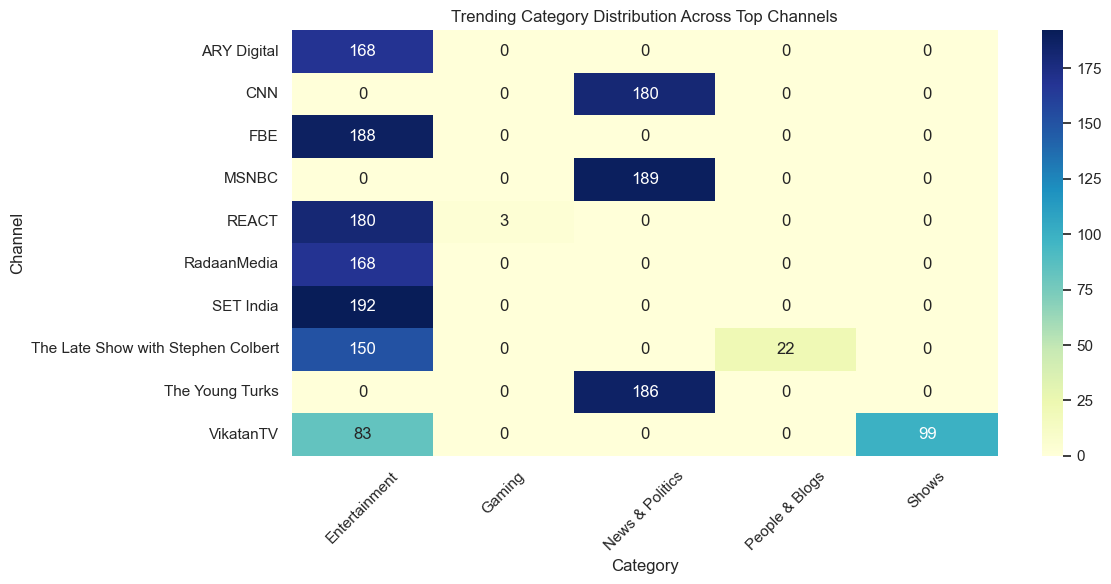

In [35]:
fig = plot_channel_category_heatmap(CA_data)
plt.show()

path = '../../outputs/plots/country_specific/CA/Trending Category Distribution Across Top Channels'
export_trend_plot(fig, str(path))

- `Format & Category Consistency in Trending Channels`

1. **High Category Consistency**:
   - Most channels with repeated trending videos tend to stick to **1–2 main categories**.
   - For example, `SET India`, `FBE`, and `RadaanMedia` focus almost exclusively on **Entertainment**.
   - Channels like `CNN`, `MSNBC`, and `The Young Turks` are consistently trending in **News & Politics**.

2. **Heatmap Patterns**:
   - The heatmap visualizes strong category dominance — most channels show one dark cell indicating category concentration.
   - A few channels (e.g., `REACT`, `The Late Show with Stephen Colbert`) show **minor diversity**, but still retain a dominant category.

3. **Possible Format Consistency**:
   - Although not directly captured in the heatmap, repeated trending by the same channel suggests **templated or serial video formats**.
   - Examples may include daily news segments, serialized dramas, or recurring show formats that create audience expectation and loyalty.

4. **Conclusion**:
   - Channels with repeated presence in trending lists tend to build a **recognizable identity** within a **single niche or format**.
   - This likely increases viewer retention and engagement, helping them trend more frequently.


### `6. Video Status & Restrictions`

- What is the impact of comments_disabled, ratings_disabled, or video_error_or_removed on engagement?

- Do videos that are later removed or error out tend to have unusually high or low engagement?

In [37]:
compare_status_impact = compare_status_impact(CA_data)

path = '../../outputs/tables/country_specific/CA/compare_status_impact'
save_table(compare_status_impact, path, format='csv')

compare_status_impact

Flag OFF       Flag ON
Flag                                                            
comments_disabled      views          1.144412e+06  1.275852e+06
                       likes          3.976756e+04  1.419507e+04
                       dislikes       1.967079e+03  1.177983e+03
                       comment_count  5.044979e+03  0.000000e+00
ratings_disabled       views          1.144680e+06  1.381676e+06
                       likes          3.967179e+04  0.000000e+00
                       dislikes       1.969162e+03  0.000000e+00
                       comment_count  5.002137e+03  7.162971e+02
video_error_or_removed views          1.146114e+06  1.401388e+06
                       likes          3.939667e+04  4.966415e+04
                       dislikes       1.955497e+03  2.479519e+03
                       comment_count  4.971371e+03  7.659444e+03

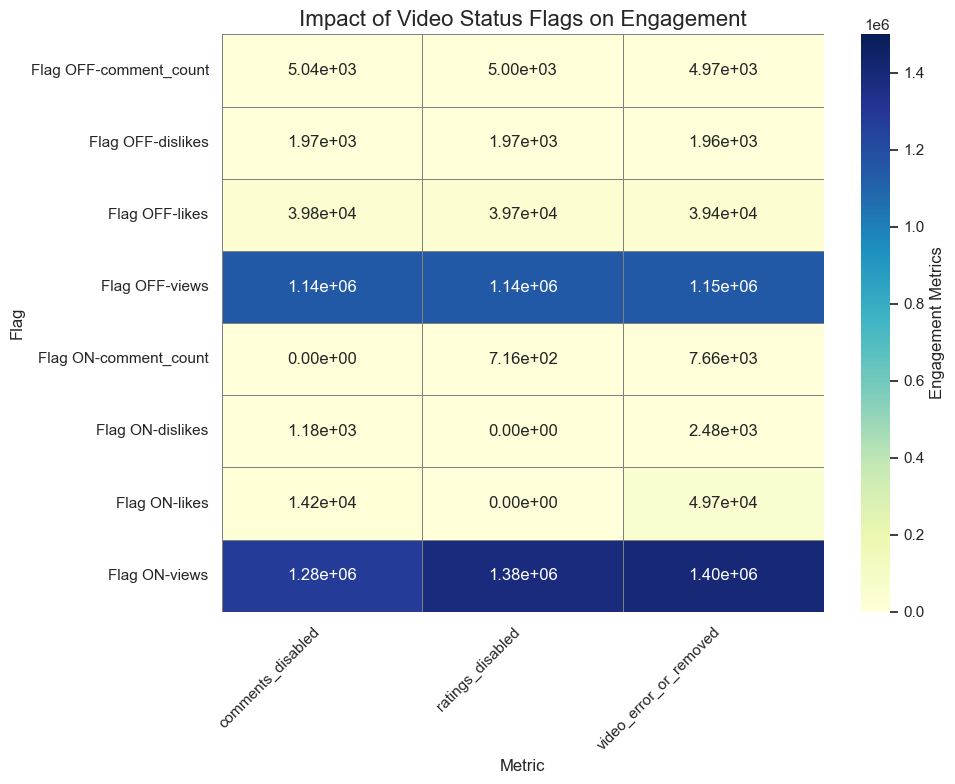

In [38]:
fig = visualize_status_impact(compare_status_impact)
plt.show()

path = '../../outputs/plots/country_specific/CA/Impact of Video Status Flags on Engagement'
export_trend_plot(fig, str(path))

- `Impact of Video Restrictions on Engagement`

We analyzed the effect of **video restrictions** such as `comments_disabled`, `ratings_disabled`, and `video_error_or_removed` on engagement metrics (views, likes, dislikes, and comment count). Below are the key insights:

---

`comments_disabled`
- **Views** are slightly **higher** when comments are disabled (`~1.28M` vs `~1.14M`), possibly indicating controversial or sensitive content that attracts attention.
- **Likes and dislikes** are **significantly lower** when comments are disabled, suggesting lower interaction overall.
- **Comment count** drops to **zero** (as expected).

*Disabling comments may limit overall interaction despite higher visibility.*

---

 `ratings_disabled`
- **Views increase** slightly when ratings are disabled (`~1.38M` vs `~1.14M`).
- **Likes and dislikes drop to zero**, confirming users can't interact via rating.
- **Comment count** also decreases significantly, indicating that ratings may encourage further interaction.

*Removing ratings reduces all forms of engagement, including comments.*

---

`video_error_or_removed`
- These videos actually show the **highest average views** (`~1.4M`), suggesting they were highly viewed before being taken down.
- **Likes, dislikes, and comments** are all **higher** than non-removed videos, showing stronger engagement before removal.

*Removed videos often had **unusually high engagement**, possibly due to controversial or viral nature before deletion.*

---

- `Conclusion`
Flags like disabling comments or ratings can **dampen audience interaction**, while videos later removed often show **elevated engagement**, hinting at viral or sensitive content. These findings can help platform moderators and content creators understand the trade-off between visibility and engagement control.
